# DMC: поиск дифференциально метилированных цитозинов

Была выбрана библиотека bsseq - https://www.bioconductor.org/packages/devel/bioc/vignettes/bsseq/inst/doc/bsseq.html.

Я использую R такой версии:

In [4]:
R.Version()$version.string

[1] "R version 4.2.1 (2022-06-23 ucrt)"

Использовать ту же версию может быть важно для одинаковой работы пакетов.

In [2]:
library(bsseq)

Сделаем рабочей директорию с cov-файлами, которые получили в результате работы Bismark:

In [5]:
setwd("D:/current_work/POLY/НИР/bismark")

Работаем с данными бисульфитного секвенирования двух диких сортов и одного элитного сорта:

| BS | WGS   | Accession name | Тип генотипа |
| -- |:-----:|:--------------:|-------------:|
| n1 | d_1   | TR83005        | Дикий вид, Kalkan_064 |
| n3 | d_3   | TR83052        | Дикий вид , Derei_070 |
| n4 | n_308 | ICCV96029      | Элитный сорт |


Для каждого сорта имеем по три биологических репликата, что обозначается так: n<номер сорта>_<номер репликата>. То есть, n4_2 соответствует второму репликату сорта 4, который, как видим по табличке сверху, является элитным.

Замечу, что постфикс _1 в названии выходных файлов Bismark не имеет смысловой нагрузки, такое имя было выбрано программой автоматически при обработке парных ридов.

Итак, для выявления дифференциальной метиляции нужно попарно сравнить репликаты первого дикого сорта(n1) c репликатами элитного(n4), а также репликаты второго дикого сорта(n1) c репликатами элитного(n4). Создаем такие группы для последующего анализа:

TODO: возмножно, имело смысл сравнить и два диких сорта между собой, но пока это не сделано.

In [6]:
samples_1vs4 = c(
    "n1_1_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n1_2_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n1_3_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_1_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_2_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_3_1_bismark_bt2_pe.deduplicated.bismark.cov.gz"
    )
samples_3vs4 = c(
    "n3_1_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n3_2_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n3_3_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_1_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_2_1_bismark_bt2_pe.deduplicated.bismark.cov.gz",
    "n4_3_1_bismark_bt2_pe.deduplicated.bismark.cov.gz"
    )

Многие операции выполняются долго, поэтому для более быстрого страрта при перезапуске jupyter notebook'а я сохраняю промежуточные результаты в бинарные файлы с расширением .rds, их можно потом прочитать прямо стурктуру данных языка R, аналогичную той, из которой они были созданы.

Здесь и далее клетки с долго выполняющимися операциями сделаны клетками типа Markdown, то есть код в них не выполняется, а отображается лишь как текст. Для удобства все промежуточные файлы лежат в репозитории. Если же Вы хотите перезаписать запомленные файлы, то сделайте клетку ниже клеткой типа Code (для этого нужно выделить клетку, нажав на боковую панель слева от нужной клетки, и нажать Y) и запустите её.

bsseq_1vs4 <- bsseq::read.bismark(samples_1vs4)
bsseq_3vs4 <- bsseq::read.bismark(samples_3vs4)
colnames(bsseq_1vs4) <- c('n1_1','n1_2','n1_3','n4_1', 'n4_2', 'n4_3')
colnames(bsseq_3vs4) <- c('n3_1','n3_2','n3_3','n4_1', 'n4_2', 'n4_3')

saveRDS(bsseq_1vs4, "bsseq_1vs4.rds")
saveRDS(bsseq_3vs4, "bsseq_3vs4.rds")

In [7]:
bsseq_1vs4 = readRDS("bsseq_1vs4.rds")
bsseq_3vs4 = readRDS("bsseq_3vs4.rds")

# Дифференциальное метилирование CpG сайтов, тест Фишера

fisher_1vs4 <- fisherTests(bsseq_1vs4, c('n1_1','n1_2','n1_3'), c('n4_1', 'n4_2', 'n4_3'))
fisher_3vs4 <- fisherTests(bsseq_3vs4, c('n3_1','n3_2','n3_3'), c('n4_1', 'n4_2', 'n4_3'))

saveRDS(fisher_1vs4, "fisher_1vs4.rds")
saveRDS(fisher_3vs4, "fisher_3vs4.rds")

In [8]:
fisher_1vs4 = readRDS("fisher_1vs4.rds")
fisher_3vs4 = readRDS("fisher_3vs4.rds")

Сделаем поправку на множественное сравнение Бенджамини-Хохберга.

- Мы изменяем именно p-values с помощью процедуры BH, они становятся больше, их мы потом сравниваем с выбранным alpha, равным, скажем, 0.01.

- Считаем, что соответствуют реальным сигналам те, что имеют BH-p-value < 0.01.

In [13]:
fisher_p_adj_1vs4 = p.adjust(fisher_1vs4$results[, 1], method = "BH", n = length(fisher_1vs4$results[, 1]))
fisher_p_adj_3vs4 = p.adjust(fisher_3vs4$results[, 1], method = "BH", n = length(fisher_3vs4$results[, 1]))

In [16]:
pval_filter_1vs4 <- fisher_p_adj_1vs4 < 0.01
pval_filter_3vs4 <- fisher_p_adj_3vs4 < 0.01

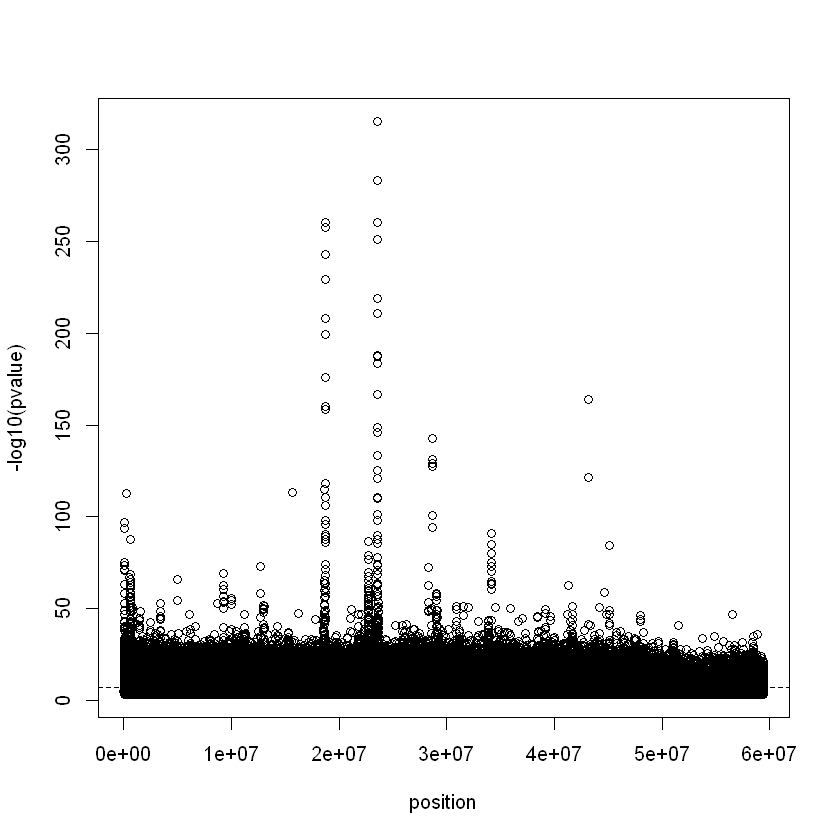

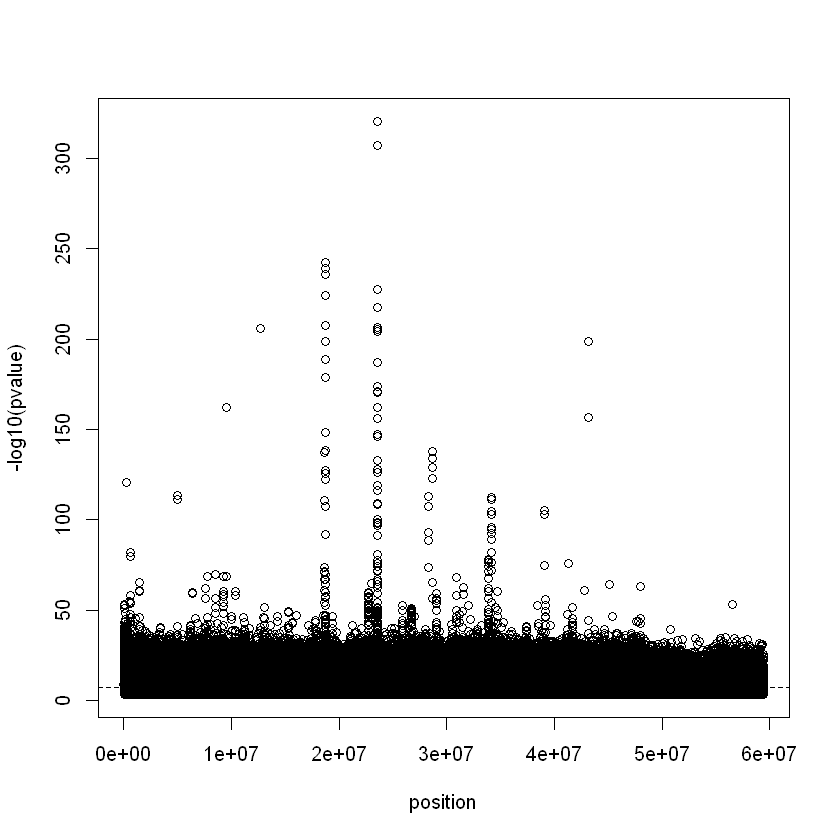

In [17]:
plot(bsseq_1vs4@rowRanges@ranges@start[pval_filter_1vs4], -log10(fisher_1vs4$results[,1][pval_filter_1vs4]), xlab='position', ylab='-log10(pvalue)')
abline(-log10(5e-8),0,lty='dashed')


plot(bsseq_3vs4@rowRanges@ranges@start[pval_filter_3vs4], -log10(fisher_3vs4$results[,1][pval_filter_3vs4]), xlab='position', ylab='-log10(pvalue)')
abline(-log10(5e-8),0,lty='dashed')

Такие графики должны иметь смысл, так как координата start, судя по всему, сквозная, то есть был задан какой-то условный порядок на хромосомах/скаффолдах, и у нас не будет несколько значений -log(pval) для одной и той же позиции.

In [22]:
head(granges(bsseq_1vs4), n = 1000000000)

GRanges object with 8558658 ranges and 0 metadata columns:
              seqnames    ranges strand
                 <Rle> <IRanges>  <Rle>
        [1]        Ca1        21      *
        [2]        Ca1        43      *
        [3]        Ca1        44      *
        [4]        Ca1       160      *
        [5]        Ca1       161      *
        ...        ...       ...    ...
  [8558654] scaffold98    703693      *
  [8558655] scaffold98    703716      *
  [8558656] scaffold98    703717      *
  [8558657] scaffold98    703730      *
  [8558658] scaffold98    703731      *
  -------
  seqinfo: 62 sequences from an unspecified genome; no seqlengths

# Подготовка файла для аннотации

Здесь нужно внимательно обращаться с координатами, что у меня вроде получилось сделать.

- Bismark выдает нам по умолчанию файлы 1-based, у них отчет начинается с 1, а интервалы пишутся в виде [a, b], то есть с включением обеих границ.

- Если мы хотим записать наши координаты дифференциально метилированных позиций в bed-файл для дальнейшего пересечения с аннотацией, то нужно придерживаться установленного соглашения об индексации в bed - используется 0-based и интервалы вида [a, b), то есть правая граница выкалывается.

- Для этого мы переводим полученные позиции в 0-based индексацию.

- bedtools при пересечении интервалов ориентируется на форматы пересекаемых файлов, поэтому это так важно.

Про индексации я читала тут:
- https://bedtools.readthedocs.io/en/latest/content/overview.html#bed-starts-are-zero-based-and-bed-ends-are-one-based
- http://genome.ucsc.edu/FAQ/FAQtracks#tracks1
- https://samtools.github.io/hts-specs/SAMv1.pdf

In [23]:
# chromsome start stop
# bismark gave us 1-based [] cov-files
# we want to turn it into 0-based [) bed file
chromStart = bsseq_1vs4@rowRanges@ranges@start[pval_filter_1vs4] - 1
chromStop = bsseq_1vs4@rowRanges@ranges@start[pval_filter_1vs4]
chrom = decode(bsseq_1vs4@rowRanges@seqnames)[pval_filter_1vs4]
bed = data.frame(chrom, chromStart, chromStop)

write.table(bed, "1vs4_001.bed", row.names = FALSE, col.names = FALSE, quote = FALSE, sep="\t")

chromStart = bsseq_3vs4@rowRanges@ranges@start[pval_filter_3vs4] - 1
chromStop = bsseq_3vs4@rowRanges@ranges@start[pval_filter_3vs4]
chrom = decode(bsseq_3vs4@rowRanges@seqnames)[pval_filter_3vs4]
bed = data.frame(chrom, chromStart, chromStop)

write.table(bed, "3vs4_001.bed", row.names = FALSE, col.names = FALSE, quote = FALSE, sep="\t")



Аннотация делалась на кластере.

Итого, я считала, что соответствуют реальным сигналам те, что имеют BH-adjusted-p-value < 0.01, что позволяет отсеять для DMC ~8млн, оставив  ~405т значимых метилляций цитозинов, из которых ~200т пересекаются с транскрибируемыми участками из аннотации.

Функциональная аннотация не производилась.
